In [15]:
import boto3
import sagemaker
import io
import chardet
import pandas as pd

In [3]:
# Create an S3 client:

s3 = boto3.client('s3')

In [16]:
# List the contents of your bucket:

bucket_name = 'mathing-map'
response = s3.list_objects_v2(Bucket=bucket_name)


In [5]:
file_keys = [obj['Key'] for obj in response['Contents']]

In [8]:
def get_df_from_s3_v1(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(obj['Body'])

In [19]:

def get_df_from_s3(bucket, key):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=key)
    
    # Leer el contenido del archivo
    content = obj['Body'].read()
    
    # Detectar la codificación
    detected = chardet.detect(content)
    encoding = detected['encoding']
    
    # Intentar diferentes codificaciones si la detección falla
    encodings_to_try = [encoding, 'utf-8', 'iso-8859-1', 'cp1252']
    
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(io.BytesIO(content), encoding=enc)
            print(f"Archivo {key} cargado exitosamente con codificación {enc}")
            return df
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"No se pudo decodificar el archivo {key} con ninguna codificación conocida")

In [20]:
# obtener tus DataFrames:

dataframes = []
for file_key in file_keys:
    try:
        df = get_df_from_s3(bucket_name, file_key)
        dataframes.append(df)
        print(f"Archivo {file_key} cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar {file_key}: {str(e)}")


Archivo Datathon_geojson/anden.csv cargado exitosamente con codificación ascii
Archivo Datathon_geojson/anden.csv cargado exitosamente.
Archivo Datathon_geojson/atractivos_turisticos.csv cargado exitosamente con codificación Windows-1252
Archivo Datathon_geojson/atractivos_turisticos.csv cargado exitosamente.
Archivo Datathon_geojson/comunas_y_corregimientos.csv cargado exitosamente con codificación ISO-8859-1
Archivo Datathon_geojson/comunas_y_corregimientos.csv cargado exitosamente.
Archivo Datathon_geojson/red_ciclista.csv cargado exitosamente con codificación ISO-8859-1
Archivo Datathon_geojson/red_ciclista.csv cargado exitosamente.


In [23]:
print(len(dataframes))
for obj in response['Contents']:
    print(obj['Key'] )

4
Datathon_geojson/anden.csv
Datathon_geojson/atractivos_turisticos.csv
Datathon_geojson/comunas_y_corregimientos.csv
Datathon_geojson/red_ciclista.csv


In [25]:
# DataFrames están en este orden en la lista 'dataframes':
# 0: anden
# 1: atractivos_turisticos
# 2: comunas_y_corregimientos
# 3: red_ciclista

# Asignar los DataFrames a variables con nombres descriptivos
comunas_df = dataframes[2]  # comunas_y_corregimientos
atractivos_df = dataframes[1]  # atractivos_turisticos

# Mostrar las primeras filas para entender la estructura del archivo de comunas
print("Estructura del archivo de comunas:")
print(comunas_df.head())
print("\n" + "="*50 + "\n")

# Filtrar los puntos turísticos que pertenecen a la comuna 4 (Aranjuez)
atractivos_comuna_4 = atractivos_df[atractivos_df['nombre_comuna'] == 'Aranjuez']

# Extraer los nombres de los puntos turísticos en la comuna 4 en una lista
attractions_comuna_4_list = atractivos_comuna_4['nombre_sitio'].tolist()

# Mostrar la lista de puntos turísticos en la comuna 4
print("Lista de puntos turísticos en la comuna 4 (Aranjuez):")
for attraction in attractions_comuna_4_list:
    print(f"- {attraction}")
print(f"\nNúmero total de atracciones en la comuna 4: {len(attractions_comuna_4_list)}")
print("\n" + "="*50 + "\n")

# Mostrar información adicional sobre los DataFrames
print("Información sobre el DataFrame de comunas:")
print(comunas_df.info())
print("\n" + "="*50 + "\n")

print("Información sobre el DataFrame de atractivos turísticos:")
print(atractivos_df.info())

Estructura del archivo de comunas:
   OBJECTID                                    Shape codigo      nombre  \
0         1  (4718611.9224620145, 2254112.982703273)     01     Popular   
1         2   (4717471.901390271, 2254648.311123495)     02  Santa Cruz   
2         3    (4718479.60763957, 2251852.493695912)     03    Manrique   
3         4  (4716680.2916398095, 2252195.029419798)     04    Aranjuez   
4         5   (4715903.412084993, 2253981.999643141)     05    Castilla   

  identificacion  limitemunicipioid  subtipo_comunacorregimiento  \
0       Comuna 1                1.0                            1   
1       Comuna 2                1.0                            1   
2       Comuna 3                1.0                            1   
3       Comuna 4                1.0                            1   
4       Comuna 5                1.0                            1   

   fecha_actualizacion  Shape_Length    Shape_Area  
0  2014-12-17 00:00:00   9604.447484  3.097941e+06  

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# DataFrames están en este orden en la lista 'dataframes':
# 0: anden
# 1: atractivos_turisticos
# 2: comunas_y_corregimientos
# 3: red_ciclista

atractivos_df = dataframes[1]  # atractivos_turisticos
ciclorrutas_df = dataframes[3]  # red_ciclista

# Filtrar los atractivos turísticos de la Comuna 4 (Aranjuez)
atractivos_comuna_4 = atractivos_df[atractivos_df['nombre_comuna'] == 'Aranjuez']

# 1. Lista de str con los nombres de los sitios turísticos en la Comuna 4
sitios_turisticos_comuna_4 = atractivos_comuna_4['nombre_sitio'].tolist()

# Verificar si hay ciclorrutas en la Comuna 4
ciclorrutas_comuna_4 = ciclorrutas_df[ciclorrutas_df['nom_comuna'] == 'Aranjuez']

# 2. Lista de tuplas que relaciona pares de sitios turísticos conectados en la Comuna 4
conexiones_comuna_4 = set()
if not ciclorrutas_comuna_4.empty:
    # Si hay ciclorrutas en la Comuna 4, conectamos todos los sitios entre sí
    for i in range(len(sitios_turisticos_comuna_4)):
        for j in range(i+1, len(sitios_turisticos_comuna_4)):
            conexiones_comuna_4.add((sitios_turisticos_comuna_4[i], sitios_turisticos_comuna_4[j]))

# Convertir el conjunto a una lista de tuplas
conexiones_lista_comuna_4 = list(conexiones_comuna_4)

# Imprimir las listas resultantes
print("Lista de sitios turísticos en la Comuna 4 (Aranjuez):")
print(sitios_turisticos_comuna_4)
print("\nNúmero de sitios turísticos en la Comuna 4:", len(sitios_turisticos_comuna_4))
print("\nLista de conexiones entre sitios en la Comuna 4:")
print(conexiones_lista_comuna_4)
print("\nNúmero de conexiones en la Comuna 4:", len(conexiones_lista_comuna_4))

# Crear un grafo
G = nx.Graph()

# Agregar nodos (sitios turísticos de la Comuna 4)
G.add_nodes_from(sitios_turisticos_comuna_4)

# Agregar aristas (conexiones por ciclorrutas en la Comuna 4)
G.add_edges_from(conexiones_lista_comuna_4)

# Visualizar el grafo
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.title("Grafo de Sitios Turísticos Conectados por Ciclorrutas en la Comuna 4 (Aranjuez)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Obtener la matriz de adyacencia
adjacency_matrix = nx.adjacency_matrix(G)

# Imprimir la matriz de adyacencia
print("\nMatriz de Adyacencia:")
print(adjacency_matrix.todense())

/tmp/ipykernel_14004/3952475558.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


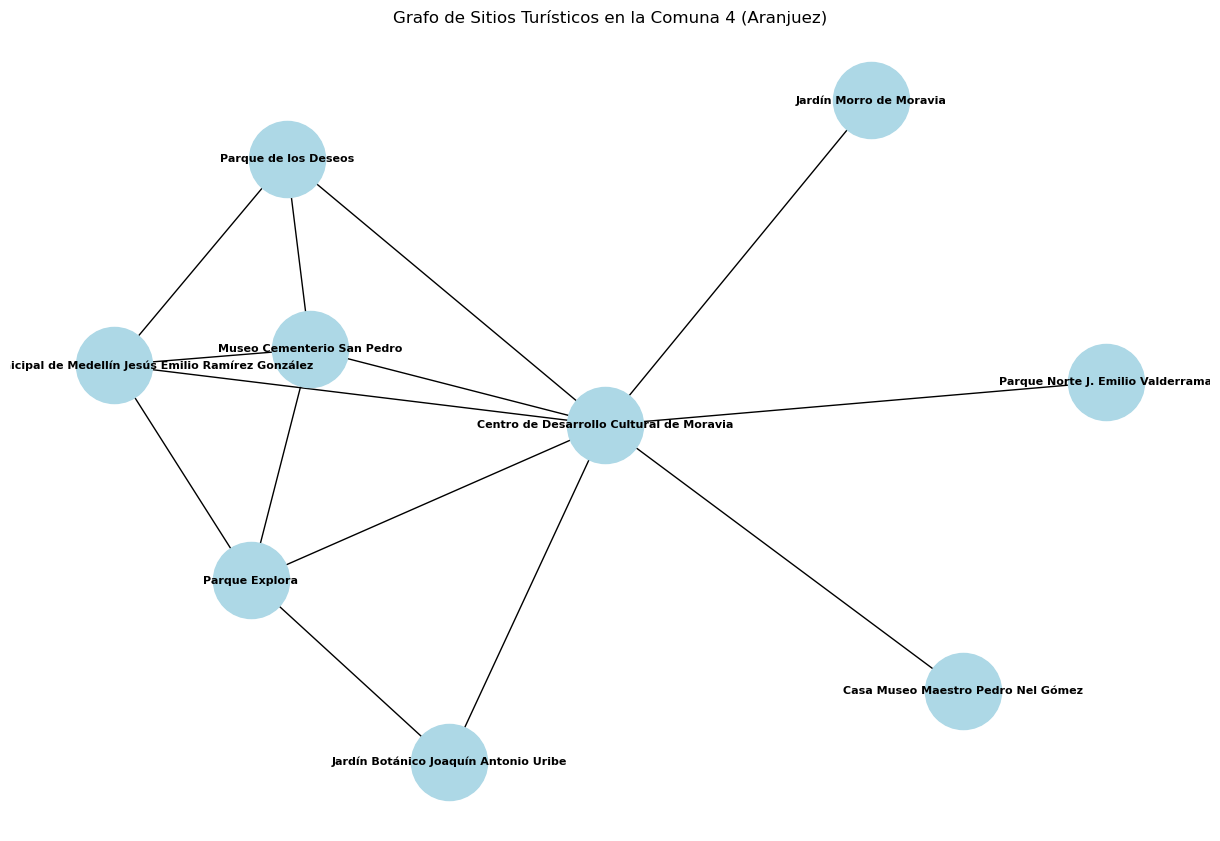

Matriz de Adyacencia:
[[0 1 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1 1 1]
 [0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 1 0 1]
 [0 1 0 0 1 0 0 0 1]
 [0 1 1 0 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 1 0 0]]

Número de nodos: 9
Número de aristas: 14

Grado de cada nodo:
Casa Museo Maestro Pedro Nel Gómez: 1
Centro de Desarrollo Cultural de Moravia: 8
Jardín Botánico Joaquín Antonio Uribe: 2
Jardín Morro de Moravia: 1
Museo Cementerio San Pedro: 4
Parque de los Deseos: 3
Parque Explora: 4
Parque Norte J. Emilio Valderrama: 1
Planetario Municipal de Medellín Jesús Emilio Ramírez González: 4

Nodo con el grado más alto: Centro de Desarrollo Cultural de Moravia (Grado: 8)

Densidad del grafo: 0.3889


In [30]:
import numpy as np
import math
from math import e
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

# Usar las listas que generamos anteriormente
sitios_turisticos = sitios_turisticos_comuna_4
conexiones = conexiones_comuna_4

# Crear un grafo vacío
G = nx.Graph()

# Agregar nodos (sitios turísticos)
G.add_nodes_from(sitios_turisticos)

# Agregar aristas (conexiones entre sitios turísticos)
G.add_edges_from(conexiones)

# Visualizar el grafo
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=3000, font_size=8, font_weight='bold')
plt.title("Grafo de Sitios Turísticos en la Comuna 4 (Aranjuez)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Obtener la matriz de adyacencia
adjacency_matrix = nx.adjacency_matrix(G)

# Imprimir la matriz de adyacencia
print("Matriz de Adyacencia:")
print(adjacency_matrix.todense())

# Información adicional sobre el grafo
print(f"\nNúmero de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")

# Calcular y mostrar el grado de cada nodo
print("\nGrado de cada nodo:")
for node in G.nodes():
    print(f"{node}: {G.degree(node)}")

# Encontrar el nodo con el grado más alto
node_max_degree = max(G.degree, key=lambda x: x[1])[0]
print(f"\nNodo con el grado más alto: {node_max_degree} (Grado: {G.degree(node_max_degree)})")

# Calcular la densidad del grafo
density = nx.density(G)
print(f"\nDensidad del grafo: {density:.4f}")